In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.layers import StringLookup
from tensorflow import keras

from PIL import Image

import pickle

The logic and the model for this notebook have been heavily inspired by A.K. Nain and Sayak Paul's Keras 'examples' contribution. [Here's a link](https://keras.io/examples/vision/handwriting_recognition/)

# Preparing and Preprocessing Data

The data set has 2 sections. 'words.txt' is the first section where it lists the file name, and then the corresponding information

format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A

     - a01-000u-00-00  -> word id for line 00 in form a01-000u (file name)
     - ok              -> result of word segmentation
                            ok: word was correctly
                            err: segmentation of word can be bad

     - 154             -> graylevel to binarize the line containing this word
     - 1               -> number of components for this word
     - 408 768 27 51   -> bounding box around this word in x,y,w,h format
     - AT              -> the grammatical tag for this word, see the
                        file tagset.txt for an explanation
     - A               -> the transcription for this word

Data (data/words.tgz) downloaded from [IAM Database](https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database)

In [2]:
base_path = '../data/IAM_Words'

In [4]:
words_list = []

words = open(f'{base_path}/words.txt', 'r').readlines()
for line in words: # go line by line
    if (line[0] != "#") and (line.split()[1] != "err"): # lines that begin with #, are useless. Ignoring errored entries as well
        
        words_list.append(line)
        

96,456 handwritten words - note that words_list is just the 'keys' of the images. We will be accessing the actual images through a function that exploits the file structure of the data

In [5]:
len(words_list)

96456

Let's look at the contents of words.txt in a df

In [6]:
bigL = []
for line in words_list:
    w_dict = {}
    l = line.strip().split()
    w_dict['word_id'] = l[0]
    #w_dict['seg_result'] = l[1]
    #w_dict['gray_level'] = l[2]
    w_dict['x'] = int(l[3])
    w_dict['y'] = int(l[4])
    w_dict['w'] = int(l[5])
    w_dict['h'] = int(l[6])
    #w_dict['grammatical_tag'] = l[7]
    w_dict['word'] = l[8]
    
    bigL.append(w_dict)
    
df = pd.DataFrame(bigL)
df.head()
    

,word_id,x,y,w,h,word
0,a01-000u-00-00,408,768,27,51,A
1,a01-000u-00-01,507,766,213,48,MOVE
2,a01-000u-00-02,796,764,70,50,to
3,a01-000u-00-03,919,757,166,78,stop
4,a01-000u-00-04,1185,754,126,61,Mr.


The x,y,w,h follows the keras bounding box format where :

- X: X coordinate of the left of the bounding box
- Y: Y coordinate of the top of the bounding box
- WIDTH: width of the bounding box
- HEIGHT: height of the bounding box


Here are the distributions of width and height of each image

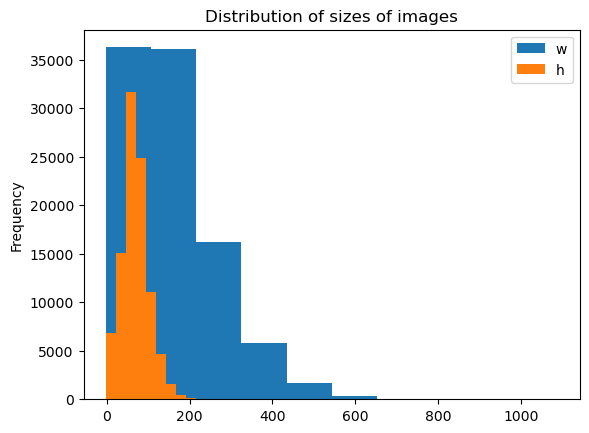

In [7]:
df['w'].plot.hist()
df['h'].plot.hist()
plt.title('Distribution of sizes of images')
plt.legend();

As expected, most of the data set has a relativelty large widht(relative to height). They are mostly all rectangular(horizontal) in nature.

In [26]:
average_width = df['w'].mean()
average_height = df['h'].mean()

print(f'Average width: {average_width} | Average height: {average_height}')

Average width: 156.63427884216637 | Average height: 69.79688147963839


## Train-Validation-Test Split

First scrambling the 'keys'

In [8]:
np.random.shuffle(words_list)

Now I'm splitting the data. 

90% will be used for training

In [9]:
split = int(0.9 * len(words_list)) # index to split train on
train = words_list[:split] # shuffled already so this is ok
test = words_list[split:]

The remaining test, will be split in half; test and val. The model will never see the new test

In [10]:
test_split = int(0.5 * len(test))
val = test[:test_split]
test= test[test_split:]

In [11]:
train[4]

'p03-103-01-02 ok 186 1092 851 66 64 PP3 it\n'

## Navigating the file structure of IAM Words

Again, words_list, train, test, and val are all 'pointers'/'keys' that point towards the actual image files

In [12]:
base_images_path = os.path.join(base_path, 'words')

First, here's a function that extracts the filepath names and labels

In [13]:
def get_paths_and_labels(IAM_keys):
    '''
    Input: IAM_keys = train, val, or test
    Output: paths, labels
            paths: full paths to access the png images
            labels: corresponding label for each image
    
    '''
    paths = []
    labels = []
    for key in IAM_keys:
        
        key_info = key.strip().split() # the strip is for the '\n'

        # Each line split will have this format for the corresponding image:
        # train[4] is 'g06-045d-05-10 ok 182 2008 1609 187 75 NP Samuel\n'
        # the corresponding file path is words/g06/g06-045d/g06-045d-05-10.png .. which is all gained from the first element of the split() string
        
        img_name = key_info[0] # img_name is now d06-003-04-04 (using above example)
        
        pseudo_name = img_name.split("-")
        folder_1 = pseudo_name[0]
        folder_2 = pseudo_name[0] + '-' + pseudo_name[1]
        img_name += '.png'
        
        img_path = os.path.join(
            base_images_path, 
            folder_1, 
            folder_2, 
            img_name
        )
        
        paths.append(img_path)
        labels.append(key_info[-1]) # We just need the word, which is the last element
        

    return paths, labels

In [14]:
train_paths, train_labels = get_paths_and_labels(train)
val_paths, validation_labels = get_paths_and_labels(val)
test_paths, test_labels = get_paths_and_labels(test)

Here's an example of a cleaned label, path, and the corresponding image

Label : it
Path : ../data/IAM_Words\words\p03\p03-103\p03-103-01-02.png


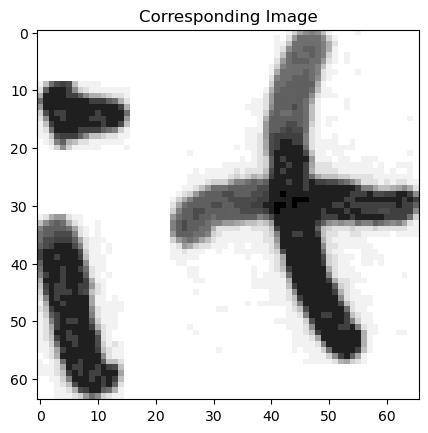

In [24]:
print(f'Label : {train_labels[4]}')
print(f'Path : {train_paths[4]}')

plt.imshow(Image.open(train_paths[4]), cmap='gray')
plt.title('Corresponding Image')
plt.show();

Here's a sneak peak of my handwriting. I found that using the .convert('L') on the PIL image, helps force the image to true grayscale mode -- usefule later for preprocessing

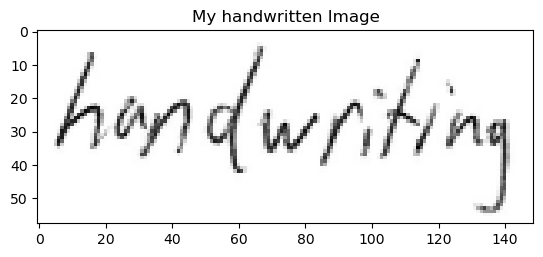

In [23]:
test_image_path = '../media/test_images/normal_4.PNG'
plt.imshow(Image.open(test_image_path).convert('L'), cmap='gray')
plt.title('My handwritten Image')
plt.show();

## Preprocessing

### Preprocessing Images

This is the function that preprocesses the image. Please read comments to see the methods and steps of the preprocessing pipeline. [Used this](https://keras.io/guides/preprocessing_layers/) to get logic

In [28]:
def preprocess_image(image_path, img_size=(128,32), flip=True):
    '''
    Reads image from path provided, and preprocesses it.
    
    Input: image_path - file path of a png, jpeg, or non-animated gif
           img_size - tuple of (new width, new Height). dimensions that the image will be resized to - set to 128,32 as default
           flip - boolean flag to denote if transposing and flipping is required - set to True as default
    
    Output: preprocessed(resized,padded,normalized) image tensor of shape (128, 32, 1) 
    '''
    # Setting the width and height of the goal image
    w, h = img_size
    
    # Get the file
    file = tf.io.read_file(image_path)
    
    # turn it into a grayscale image tensor that's easy for tf to use
    image_tensor = tf.image.decode_png(file, 1)
    
    
    # Resize the image into the provided width and height rectangle. 
    resized_image = tf.image.resize(image_tensor, 
                                    size=(h, w), # A 1-D int32 Tensor of 2 elements: new_height, new_width. The new size for the images.
                                    preserve_aspect_ratio=True # don't want to stretch it
                                    ) 
    
    # Now that image is resized, we need to determine the padding.
    
    # Check the amount of padding needed to be done .. tf.shape - gives (h,w)
    pad_height = h - tf.shape(resized_image)[0]  
    pad_width = w - tf.shape(resized_image)[1]

    # We want equal padding on top/bottom and left/right. This is how we determine those values
    
    # top and bottom padding (half top, half bottom)
    if pad_height % 2 != 0: 
        height = pad_height // 2
        top = height + 1
        bottom = height
    else:
        top = pad_height // 2
        bottom = top
        
    # now left and right padding (half left, half right)
    if pad_width % 2 != 0:
        width = pad_width // 2
        left = width + 1
        right = width
    else:
        left = pad_width // 2
        right = left
    
    # Padding the image
    image = tf.pad(
        resized_image,
        paddings = [
            [top, bottom],
            [left, right],
            [0, 0], # this is to add padding to color channels. since we're working with greyscale, no change is needed
            ],
        )
    
    # if the Flip flag is true(default): 
    if flip:
        # Transposing the image. This swaps the rows and columns of the image. It's needed for the weird way that the shapes are (h,w) rather than (w,h)
        image = tf.transpose(image, perm=[1, 0, 2])
    
        # Flipping the image to account for reflection 
        image = tf.image.flip_left_right(image)
    
    # Finally, casting the values of the tensor to floats, then normalizing the values(by dividing each value by 255)
    image = tf.cast(image, tf.float32) / 255.0
    
    return image

Here are some examples of what the above function does to an image

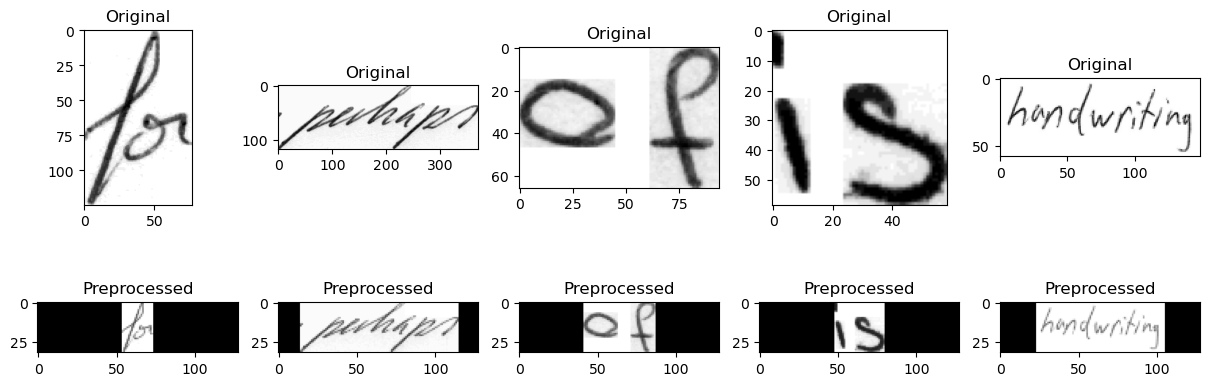

In [29]:
plt.figure(figsize=(15, 5))
temp_paths = train_paths[:4] + [test_image_path]

for i in range(5):
    plt.subplot(2, 5, i + 1)
    im = Image.open(temp_paths[i]).convert('L')
    plt.imshow(im, cmap='gray')
    plt.title("Original")

for i in range(5):
    plt.subplot(2, 5, i + 6)
    cleaned_im = preprocess_image(temp_paths[i], flip=False)
    plt.imshow(cleaned_im, cmap='gray')
    plt.title("Preprocessed")

### Preprocessing Labels

We have to make all the labels uniform before they can be ingested by the model. So we'll have to pad the labels and 'tokenize' them as well.

In order to do that, we have to find the max number of characters in a label for the entire corpus of train labels, and then, find each unique character in that corpus(characters set)

In [30]:
character_set = set() 

lengths = [] # just a temporary list to store all the lengths of the labels

for label in train_labels:
    for char in label:
        character_set.add(char)

    lengths.append(len(label))

max_len = max(lengths)

print(f'Max Length: {max_len}')
print(f'Character Set: {sorted(list(character_set))}')
print(f'Character Set Length: {len(character_set)}')

Max Length: 21
Character Set: ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Character Set Length: 78


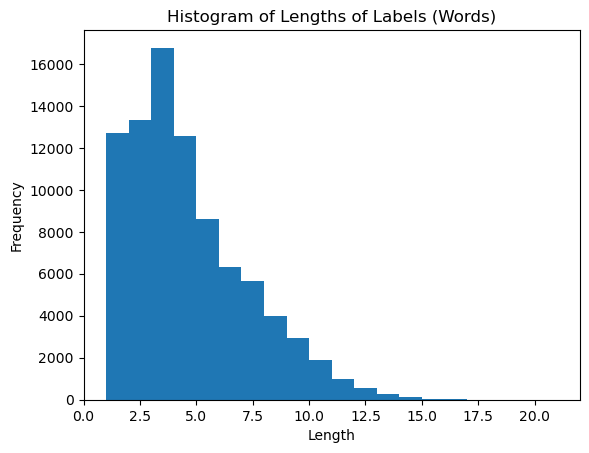

In [31]:
plt.hist(lengths, bins=20)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths of Labels (Words)')

plt.show()

Here's a histogram of another OCR researcher who had a different dataset. [From Here](https://www.researchgate.net/publication/337184022_Text_classification_with_pixel_embedding)

<img src = ../media/research_histogram.PNG>

Just based on this, with no other information, I'm going to make an assumption that our dataset is heavily influenced by shorter words

So there are 26 letters ( 52 lower and upper) + 10 digits + 16 punctuation chars = 78 vocab size

[Used this](https://keras.io/guides/preprocessing_layers/) to create a 'tokenize' and 'untokenize' objects/mappers

In [33]:
# Characters -> Integers
tokenize = StringLookup(
    vocabulary = list(character_set), 
    mask_token=None
)

# Integers -> Characters
untokenize = StringLookup(
    vocabulary = tokenize.get_vocabulary(), 
    mask_token=None, 
    invert=True
)

This is the utility function to preprocess the labels. [Used this](https://keras.io/guides/preprocessing_layers/) for logic

In [34]:
def vectorize_label(label, max_len=21, padding_token=99):
    '''
    Vectorizes the labels and pads them to the max_len amount
    
    Uses the tokenize function created above with StringLookup()
    
    Input: label - string
           max_len - max length of total strings in dataset... found to be 21 in train
           padding_token - what to pad the end of the word with .. default is 99
    
    Output: vectorized label of type _ with a shape of (21,)
    
    '''
    # tokenize is the StringLookup object defined in the cell above
    label = tokenize(tf.strings.unicode_split(label, input_encoding="UTF-8")) 
    
    # finding the actual length of the label (word)
    length = tf.shape(label)[0]
    
    # determining the amount of padding required for this word
    pad_amount = max_len - length
    
    # Padding
    label = tf.pad(
        label, 
        paddings = [
            [0, pad_amount]# padding to the right of the words
        ], 
        constant_values = padding_token # pads with the oov token: 99
    )
    return label

Here's an example of what the function does

In [35]:
print(f'Original Label: {train_labels[0]}')
print(f'Processed Label: {vectorize_label(train_labels[0])}')

Original Label: for
Processed Label: [74 28 30 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]


### Putting it all together

Functions to combine images and labels, and get them ready for model ingestion. Utilized tensorflow's 'fetching' and batching protocols.

[Used this](https://keras.io/guides/preprocessing_layers/) to get logic

Walkthrough of logic is commented

In [36]:
def combine_images_labels(image_path, label):
    '''
    Uses the preprocess_image function. and the vectorize_label function and then combines them so that each image corresponds with it's label
    
    Input: image_path - path to image file
           label - string label for the corresponding image

    Output: a single dictionary with two keys(processed image and processed label)
    '''
    processed_image = preprocess_image(image_path)
    processed_label = vectorize_label(label)
    return {"image": processed_image, "label": processed_label}


def prepare_dataset(image_paths, labels, batch_size=64, AUTOTUNE= tf.data.AUTOTUNE):
    '''
    Asynchronously takes in image paths and labels, 
         processes them(by calling the above function), 
         and then outputs the data as tf.PrefetchFatset objects for optimized parallelization
         
    Input: image_paths - list of image paths(strings)
           labels - list of labels(strings)
           batch_size - used to determine batching (better to use power of 2) - default is 64
           AUTOTUNE - this is a value that tells tf what the optimal way to load data is - default is the tf.data.AUTOTUNE constant
    
    Output: A special datatype that only releases information piecewise(according to batch size)
         datatype is tensorflow.python.data.ops.prefetch_op._PrefetchDataset
         It is essentially, a series of dictionaries, where each dictionary corresponds to each image tensor-label tensor combo
    
    '''
    
    # First, create a tensor flow dataset that slices the image_paths and labels lists.
    # the resulting tuple_dataset is a tf dataset object that has a bunch of tuples, where each tuple consists of an image path and its label.
    # pretty much like zip()
    tuple_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Now we call the processing function(s) to 
    dataset = tuple_dataset.map(
        combine_images_labels,  # applies the helper function defined above(preprocesses everything)
        num_parallel_calls=AUTOTUNE # does it in such a way that maximizes memory efficiency
    )
    
    # batches the data, 
    # caches it for faster access, 
    # and prefetches elements to ensure a smooth and efficient training process
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE) 

In [37]:
train_ds = prepare_dataset(train_paths, train_labels)
val_ds = prepare_dataset(val_paths, validation_labels)
test_ds = prepare_dataset(test_paths, test_labels)

Let's take a look at the output of this function. Here's some information about the datatypes of the prefetch datasets that are outputted from the above functions.

In [38]:
for data in train_ds.take(1):# take(1) is a method that just get's 1 single batch from the dataset
    print(f'Types of objects in dataset: {type(data)}')
    images = data['image']
    labels = data['label']
    print(f'Shape of Images{images.shape}')
    print(f'Shape of Labels: {labels.shape}')
    

Types of objects in dataset: <class 'dict'>
Shape of Images(64, 128, 32, 1)
Shape of Labels: (64, 21)


# Modeling

The model will be using CTC Loss.

<img src = ../media/model_structure.PNG>

Image from [here](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)

CTC loss is used in sequence-to-sequence tasks where you have an input sequence (image of handwriting) and an output sequence (a sequence of characters).

Here's an example of using CTC to classify words:

<img src = ../media/ctc_example.PNG>

Image from [here](https://sid2697.github.io/Blog_Sid/algorithm/2019/10/19/CTC-Loss.html#:~:text=Connectionist%20Temporal%20Classification%20(CTC)%20is,the%20training%20process%20more%20straightforward.)



CTC loss accounts for situations where you might not have a one-to-one mapping between input and output sequences. For example, in handwritten text recognition, multiple characters might be written closely together or have gaps in between.

By using CTC loss, we can train our model to handle these variations and produce the correct transcriptions.

[Here's](https://distill.pub/2017/ctc/) a thorough explanation of CTC loss


In [41]:
class CTCLayer(keras.layers.Layer):
    '''
    Layer creation to put at the end of our model.
    
    Code from:
    https://keras.io/examples/vision/handwriting_recognition/
    '''
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [46]:
def build_model():
    '''
    This model was built by  A.K.Nain and Sayak Paul.
    
    Source code can be found here: https://keras.io/examples/vision/handwriting_recognition/
    
    '''
    image_width = 128
    image_height = 32
    
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(tokenize.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

In [47]:
# Model Summary
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

## Edit distance

Edit distance is a measure of the similarity between two strings in terms of the minimum number of edit operations required to transform one string into the other. Edit operations are things like insertions, deletions, and substitutions

We will be using this metric to evaluate our model

In [52]:
validation_images = []
validation_labels = []

for data in val_ds:
    validation_images.append(data["image"])
    validation_labels.append(data["label"])


def calculate_edit_distance(labels, predictions):
    '''
    Calculates edit distance between label and the prediction. 
    
    converts labels and predictions into tensors and utilizes tf.edit_distance()
    
    Source code can be found here: https://keras.io/examples/vision/handwriting_recognition/
    
    '''
    # Get a single batch and convert its labels to sparse tensors.
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), 
        dtype = tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, 
        sparse_labels, 
        normalize=False
    )
    
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

## Training

The following is markdown of the model Training. For illustrative purposes, we will be using a pickled model  for the rest of the notebook

```python
model = build_model()

# Creating a subset of the original model. 
#  This new model is used to make predictions on input data.
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, # input from the "image" layer of  model 
    model.get_layer(name="dense2").output # produces the output from the "dense2" layer of model
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[edit_distance_callback],
    verbose = 2
)
```

Plotting the loss change for the model

In [58]:
def plot_loss(history):
    '''
    Given a model history(history), plots val and train loss as epochs increase
    
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2,1)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Edit Distance')
    plt.legend()

    plt.show()
    
#plot_loss(history)

Here's the output of plot_loss(history)

<img src = ../media/loss_plot.PNG>


# Inference

Let's investigate how to best use this model. Here we load a pretrained model

In [60]:
loaded_test= keras.models.load_model(
    "../models_pickles/prediction_model_2.keras",
    custom_objects={
        'CTCLayer': CTCLayer
    }
)

In [ ]:
test_image_path = '../media/test_images/normal_4.PNG'
string_label = 'handwriting'
test_image = np.asarray(Image.open(test_image_path).convert('L'))
plt.imshow(test_image, cmap='gray')
plt.title('Corresponding Image')
plt.show();
print(test_image.shape)
processed_test = preprocess_image(test_image, img_size=(image_width, image_height))
print(processed_test.shape)

tf.Tensor([49 47 49 75  8  8 50 99 99 99 99 99 99 99 99 99 99 99 99 99 99], shape=(21,), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


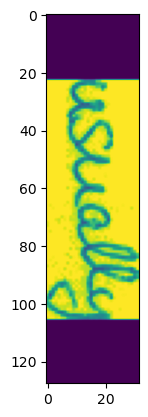

In [72]:
for data in test_ds.take(1):
    images = data['image']
    labels = data['label']
    index = 30
    print(labels[index])
    plt.imshow(images[index])
    
    print(type(images[index]))

In [61]:
for data in test_ds.take(1):
    images = data['image']
    labels = data['label']
    
    typ
    
    preds = loaded_test.predict(images)
    print(f'Prediction shape: {preds.shape}')
    print(f'Number of samples in data: {preds.shape[0]}')
    print(f'Sequence Length: {preds.shape[1]}')
    

2/2 [==============================] - 1s 38ms/step
Prediction shape: (64, 32, 81)
Number of samples in data: 64
Sequence Length: 32


The network outputs are probabilities over character classes at each time step. In order to interpret these, we need to use a ctc decoder. Keras has one: keras.backend.ctc_decode()

Here's a utility function that uses the decoder to interpret the predictions

In [73]:
def decode_batch_predictions(pred, max_len = 21):
    '''
    Converts the model.predict() sequences into meaningful text sequences
    *REQUIRES* the 'untokenize' StringLookup() object created earlier in the notebook
    
    Input: pred - predictions from the model
           max_len - max sequence length used when creating the tokenize/untokenize objects - default is 21
    
    Output:  returns a list of the decoded text for each input sequence in the batch
    
    '''
    
    # Decode the sequences from model.predict()
    results = keras.backend.ctc_decode(
        pred, 
        input_length = np.ones(pred.shape[0]) * pred.shape[1], # a NumPy array of ones multiplied by the length of the predictions 
        greedy=True)[0][0][:, :max_len] # ensures that the sequences don't exceed the max_len
    
    
    # Iterate over the decoded results and obtain the text.
    output_text = []
    for res in results:
        
        # remove -1 (blank label) from the decoded result
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        
        # uses the untokenize object(from where we tokenized the labels) to turn the integers into strings
        res = tf.strings.reduce_join(untokenize(res)).numpy().decode("utf-8")
        
        output_text.append(res)
        
    return output_text

Ok let's test it out

2/2 [==============================] - 0s 38ms/step


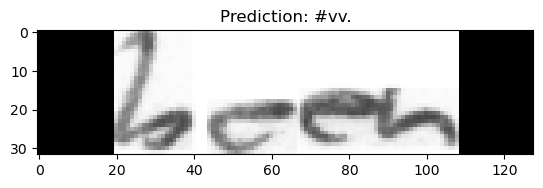

In [74]:
index = 50

for data in test_ds.take(1):
    images = data['image']
    labels = data['label']
    
    preds = loaded_test.predict(images)
    pred_texts = decode_batch_predictions(preds)
    
    
    img = images[index]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]
    
    plt.imshow(img, cmap="gray")
    plt.title(f'Prediction: {pred_texts[index]}')
    
    

2/2 [==============================] - 0s 48ms/step


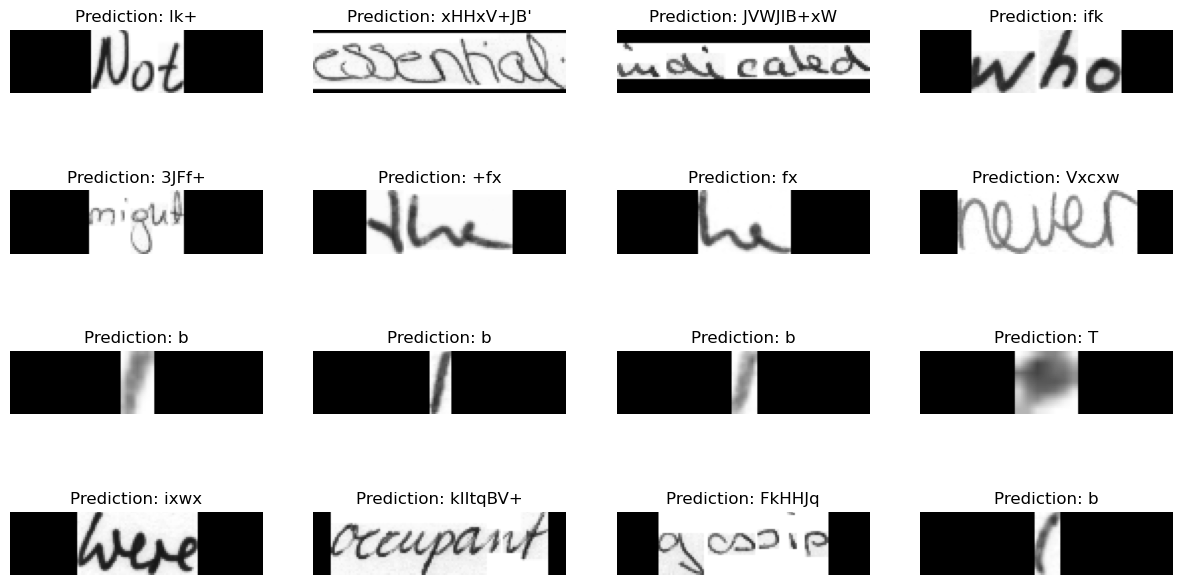

In [154]:
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = loaded_test.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()